# Atividade 8 - Classificador MLP

# Dataset Completo - Normalizado

# Algoritmo MLPClassifier

● Seguir o mesmo padrão das atividades 6 e 7, mas agora para redes MLP

● Realizar validação cruzada para testar redes neurais (mesmos subconjuntos utilizados em SVMs)
utilizando:

    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)
    
Em cada um, calibrar os parâmetros (número de neurônios da camada oculta (ex: 10, raiz quadrada
do nr de características, um nr maior), taxa de aprendizado (ex: 0,1; 0,01), função de ativação
(sigmoide na camada de saída, mas na camada oculta testar tangente hiperbólica e leaky relu (ou
relu)) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou
melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math


from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.neural_network import MLPClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


## Pré-Processamento

In [3]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [4]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [5]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [6]:
df_imp = df_processed.copy()

In [7]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [8]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    n_Neurons_range = grid_params.get('n_Neurons_range')
    n_layers_range = grid_params.get('n_layers_range')
    learning_rate_init_range = grid_params.get('learning_rate_init_range')
    f_Activation = grid_params.get('f_Activation')
    momentum_range = grid_params.get('momentum_range')
    max_iter = grid_params.get('max_iter')
    early_stopping = grid_params.get('early_stopping')   
    
    # Testa varias funções de ativação
    for func in f_Activation:
        print("-> Teste função {}".format(func))
        
        # Testa para 1 a n layers
        for layers in list(np.arange(n_layers_range[0], n_layers_range[1]+1, 1)):
            
            # Calcula o numero de possiveis configuracoes de MLP (n de layers e neuronios por layers)
            n_possibilidades = pow(len(n_Neurons_range),layers)

            # Monta uma tuple com a configuracao atual
            for i in range (n_possibilidades):
                config = tuple()
                encoded = i
                for j in range (layers):
                    new_neuron = math.floor(encoded / pow(len(n_Neurons_range),(layers - j - 1)))

                    config = config + (n_Neurons_range[new_neuron], )
                    encoded = encoded % math.pow(len(n_Neurons_range),(layers - j - 1))

        
                # Testa varios learning_rate
                for learning_rate_i in learning_rate_init_range:

                    # Testa vários momentums para o sgd
                    for momentum in momentum_range:
                    
                        # Testa vários valores maximos de iteracao
                        for iters in max_iter:
                        
                            # Testa com e sem early stop
                            for stop in early_stopping:
                                
                                print('-> Modelo: func ={} | params {} | learning_rate={:.3f} | momentum = {:.2f} | max_iter = {} | early_stopping = {}'.format(
                                    func, config, learning_rate_i, momentum,iters, stop))
                                pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                                           ('clf', algoritmo(activation=func, hidden_layer_sizes=config, learning_rate_init=learning_rate_i, 
                                                            solver = 'sgd', momentum = momentum,max_iter = iters,early_stopping = stop,
                                                            verbose=0, random_state = random_state))])

                                # Folds
                                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                                    fold_number = fold
                                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                                    # quantidade de classes dentro da fold
                                    #REMOVED

                                    # aplica o classificador
                                    pipe_clf.fit(X_train, y_train)

                                    # predict no dataset de treino 
                                    y_train_preds = pipe_clf.predict(X_train)
                                    # predict no dataset de teste
                                    y_pred = pipe_clf.predict(X_test)


                                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                                    recall = recall_score(y_test, y_pred)
                                    accuracy = accuracy_score(y_test, y_pred)
                                    precision = precision_score(y_test, y_pred)
                                    scores.append([config, learning_rate_i, func, momentum, iters, stop,
                                                  pipe_clf['clf'].n_iter_, fold_number, precision, recall, accuracy])



    return np.array(scores)

### Dataset Balanceado

In [9]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    n_Neurons_range = grid_params.get('n_Neurons_range')
    n_layers_range = grid_params.get('n_layers_range')
    learning_rate_init_range = grid_params.get('learning_rate_init_range')
    f_Activation = grid_params.get('f_Activation')
    momentum_range = grid_params.get('momentum_range')
    max_iter = grid_params.get('max_iter')
    early_stopping = grid_params.get('early_stopping')   
    
    # Testa varias funções de ativação
    for func in f_Activation:
        print("-> Teste função {}".format(func))
        
        # Testa para 1 a n layers
        for layers in list(np.arange(n_layers_range[0], n_layers_range[1]+1, 1)):
            
            # Calcula o numero de possiveis configuracoes de MLP (n de layers e neuronios por layers)
            n_possibilidades = pow(len(n_Neurons_range),layers)

            # Monta uma tuple com a configuracao atual
            for i in range (n_possibilidades):
                config = tuple()
                encoded = i
                for j in range (layers):
                    new_neuron = math.floor(encoded / pow(len(n_Neurons_range),(layers - j - 1)))

                    config = config + (n_Neurons_range[new_neuron], )
                    encoded = encoded % math.pow(len(n_Neurons_range),(layers - j - 1))
                    
                # Testa varios learning_rate
                for learning_rate_i in learning_rate_init_range:

                    # Testa vários momentums para o sgd
                    for momentum in momentum_range:
                    
                        # Testa vários valores maximos de iteracao
                        for iters in max_iter:
                        
                            # Testa com e sem early stop
                            for stop in early_stopping:
                                
                                print('-> Modelo: func ={} | params {} | learning_rate={:.3f} | momentum = {:.2f} | max_iter = {} | early_stopping = {}'.format(
                                    func, config, learning_rate_i, momentum,iters, stop))
                                
                                pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                                       ('clf', algoritmo(activation=func, hidden_layer_sizes=config, learning_rate_init=learning_rate_i, 
                                                        solver = 'sgd', momentum = momentum,max_iter = iters,early_stopping = stop,
                                                        verbose=0, random_state = random_state))])

                                # Folds
                                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                                    fold_number = fold
                                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                                    # Normaliza MinMax para aplicar Smote
                                    X_train_normalized = minmax_scale.fit_transform(X_train)
                                    X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                                    # SMOTETomek (apenas os dados de treino)
                                    #print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                                    X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                                    # Retorna para valores não normalizados
                                    X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())

                #                    print folds balanceados
                                    #REMOVED

                                    # quantidade de classes dentro da fold
                                    #REMOVED

                                    # aplica o classificador
                                    pipe_clf.fit(X_train, y_train)
                                    #display(clf)

                                    # predict no dataset de treino 
                                    y_train_preds = pipe_clf.predict(X_train)
                                    # predict no dataset de teste
                                    y_pred = pipe_clf.predict(X_test)


                                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                                    recall = recall_score(y_test, y_pred)
                                    accuracy = accuracy_score(y_test, y_pred)
                                    precision = precision_score(y_test, y_pred)
                                    scores.append([config, learning_rate_i, func, momentum, iters, stop,
                                                   pipe_clf['clf'].n_iter_, fold_number, precision, recall, accuracy])

            
    return np.array(scores)

## Grid de Parametros para teste

In [10]:
grid_params_all = {'n_Neurons_range': [5,7,10,15,20],
                   'n_layers_range' : [1,2],
               'learning_rate_init_range': [0.001, 0.01, 0.1],
               'f_Activation': ['logistic', 'tanh', 'relu'],
                'momentum_range': [0.3, 0.6,  0.9],
                'max_iter':[300],
                'early_stopping':[True,False]
              }



## Calculando Precisão, Revocação e Acurácia

### Algortimo-> MLPClassifier

### Dataset Desbalanceado

In [11]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_imp, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Configuration', 1: 'learning_rate_init', 2: 'f_Activation',
                                                        3:'Momentum', 4:'Max_iters', 5:'Early_stop', 6:'n_iters',
                                                        7:'Fold', 8: 'Precision', 9: 'Recall', 10: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'MLPClassifier'
float_cols = ['learning_rate_init', 'Momentum', 'Max_iters', 'n_iters', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste função logistic
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.010

In [12]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Dataset_Completo_Normalizado_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,n_iters,Fold,Precision,Recall,Accuracy,Algorimto
0,"(5,)",0.001,logistic,0.3,300,True,12,1,0.058140,1.000000,0.058140,MLPClassifier
1,"(5,)",0.001,logistic,0.3,300,True,12,2,0.058140,1.000000,0.058140,MLPClassifier
2,"(5,)",0.001,logistic,0.3,300,True,12,3,0.058140,1.000000,0.058140,MLPClassifier
3,"(5,)",0.001,logistic,0.3,300,True,60,4,0.666667,0.333333,0.941860,MLPClassifier
4,"(5,)",0.001,logistic,0.3,300,True,59,5,0.000000,0.000000,0.906977,MLPClassifier


### Dataset Balanceado

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_imp, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_balanced = scores_balanced.rename(columns = {0: 'Configuration', 1: 'learning_rate_init', 2: 'f_Activation',
                                                        3:'Momentum', 4:'Max_iters', 5:'Early_stop', 6:'n_iters',
                                                        7:'Fold', 8: 'Precision', 9: 'Recall', 10: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'MLPClassifier'
float_cols = ['learning_rate_init', 'Momentum', 'Max_iters', 'n_iters', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste função logistic
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.30 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.60 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = True
-> Modelo: func =logistic | params (5,) | learning_rate=0.001 | momentum = 0.90 | max_iter = 300 | early_stopping = False
-> Modelo: func =logistic | params (5,) | lea

In [14]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Dataset_Completo_Normalizado_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,n_iters,Fold,Precision,Recall,Accuracy,Algorimto
0,"(5,)",0.001,logistic,0.3,300,True,12,1,0.058140,1.0,0.058140,MLPClassifier
1,"(5,)",0.001,logistic,0.3,300,True,12,2,0.058140,1.0,0.058140,MLPClassifier
2,"(5,)",0.001,logistic,0.3,300,True,12,3,0.058140,1.0,0.058140,MLPClassifier
3,"(5,)",0.001,logistic,0.3,300,True,12,4,0.069767,1.0,0.069767,MLPClassifier
4,"(5,)",0.001,logistic,0.3,300,True,12,5,0.069767,1.0,0.069767,MLPClassifier


## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [15]:
mean_unbalanced = scores_unbalanced.groupby(['Configuration', 'learning_rate_init', 'f_Activation',
                                             'Momentum', 'Max_iters', 'Early_stop']).mean().drop('Fold', axis = 1)
mean_unbalanced

n_iters  Precision    Recall  Accuracy
Configuration learning_rate_init f_Activation Momentum Max_iters Early_stop                                        
(5,)          0.001              logistic     0.3      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           39.4   0.174419  0.466667  0.574186
                                              0.6      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           38.9   0.190000  0.130000  0.916047
                                              0.9      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           20.6   0.060000  0.060000  0.923064
                                 relu         0.3      300       False         300.0   0.366905  0.240000  0.926566
                                                                 True           38.3   0.221081  0.963333  0.764432
                                              0.6      300       False         300.0   0.390000  0.136667  0.934733
                                                                 True           34.6   0.232655  0.873333  0.792394
                                              0.9      300       False         300.0   0.691667  0.493333  0.954569
                                                                 True           38.8   0.313618  0.336667  0.903187
                                 tanh         0.3      300       False         300.0   0.435198  0.580000  0.916033
                                                                 True           20.0   0.219189  0.736667  0.798317
                                              0.6      300       False         300.0   0.523611  0.546667  0.934706
                                                                 True           17.3   0.223372  0.736667  0.799466
                                              0.9      300       False         300.0   0.763333  0.580000  0.960369
                                                                 True           47.6   0.393095  0.580000  0.907866
              0.010              logistic     0.3      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           16.6   0.153333  0.093333  0.930082
                                              0.6      300       False         300.0   0.000000  0.000000  0.935910
                                                                 True           14.3   0.191667  0.093333  0.927702
                                              0.9      300       False         292.1   0.756190  0.656667  0.962695
                                                                 True           13.0   0.091667  0.060000  0.933584
                                 relu         0.3      300       False         300.0   0.685833  0.603333  0.956867
                                                                 True           35.2   0.426753  0.316667  0.917168
                                              0.6      300       False         281.2   0.654405  0.656667  0.955705
                                                                 True           28.5   0.516905  0.256667  0.932380
                                              0.9      300       False         203.6   0.672500  0.713333  0.956867
                                                                 True           16.0   0.335238  0.190000  0.927729
                                 tanh         0.3      300       False         300.0   0.728095  0.636667  0.960369
                                                                 True           43.0   0.425238  0.563333  0.918386
                                              0.6      300       False         282.9   0.691548  0.710000  0.959207
                 

In [16]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

,,,,,,n_iters,Precision,Recall,Accuracy
Configuration,learning_rate_init,f_Activation,Momentum,Max_iters,Early_stop,,,,
"(10,)",0.01,logistic,0.9,300,False,248.3,0.781190,0.676667,0.965048
"(20,)",0.01,logistic,0.9,300,False,210.1,0.771190,0.676667,0.963885
"(20, 15)",0.10,logistic,0.3,300,False,300.0,0.771190,0.676667,0.963885
"(15, 15)",0.10,logistic,0.3,300,False,300.0,0.772857,0.656667,0.963871
"(20, 10)",0.10,logistic,0.3,300,False,300.0,0.772857,0.656667,0.963871


((10,), 0.01, 'logistic', 0.9, 300, False)

### Dataset Balanceado

In [17]:
mean_balanced = scores_balanced.groupby(['Configuration', 'learning_rate_init', 'f_Activation', 
                                         'Momentum', 'Max_iters','Early_stop']).mean().drop('Fold', axis = 1)
mean_balanced

n_iters  Precision    Recall  Accuracy
Configuration learning_rate_init f_Activation Momentum Max_iters Early_stop                                        
(5,)          0.001              logistic     0.3      300       False         240.3   0.168684  0.906667  0.599480
                                                                 True           12.0   0.064172  1.000000  0.065253
                                              0.6      300       False         300.0   0.312349  0.853333  0.854200
                                                                 True           12.0   0.064172  1.000000  0.065253
                                              0.9      300       False         300.0   0.586800  0.876667  0.944022
                                                                 True           20.0   0.096313  0.960000  0.213762
                                 relu         0.3      300       False         300.0   0.366287  0.800000  0.884555
                                                                 True           41.8   0.187147  0.833333  0.743461
                                              0.6      300       False         300.0   0.476565  0.836667  0.918427
                                                                 True           32.5   0.188826  0.813333  0.751628
                                              0.9      300       False         300.0   0.593889  0.803333  0.947538
                                                                 True           47.6   0.302283  0.783333  0.847209
                                 tanh         0.3      300       False         300.0   0.371371  0.873333  0.879863
                                                                 True           49.0   0.252429  0.600000  0.846115
                                              0.6      300       False         300.0   0.435657  0.856667  0.902079
                                                                 True           50.8   0.283368  0.653333  0.856580
                                              0.9      300       False         300.0   0.599261  0.836667  0.947510
                                                                 True           57.3   0.371550  0.873333  0.879850
              0.010              logistic     0.3      300       False         300.0   0.607698  0.893333  0.949850
                                                                 True           41.4   0.231219  0.910000  0.788960
                                              0.6      300       False         300.0   0.629939  0.893333  0.953365
                                                                 True           36.6   0.254905  0.890000  0.814637
                                              0.9      300       False         286.9   0.592633  0.836667  0.946389
                                                                 True           38.2   0.494181  0.860000  0.928865
                                 relu         0.3      300       False         300.0   0.608030  0.823333  0.949863
                                                                 True           52.1   0.358886  0.800000  0.882093
                                              0.6      300       False         298.7   0.610570  0.823333  0.948714
                                                                 True           38.1   0.405198  0.800000  0.889056
                                              0.9      300       False         295.0   0.561457  0.783333  0.940561
                                                                 True           26.9   0.522399  0.853333  0.931259
                                 tanh         0.3      300       False         300.0   0.621270  0.856667  0.952175
                                                                 True           50.5   0.375653  0.853333  0.883338
                                              0.6      300       False         287.1   0.602421  0.856667  0.949850
                 

In [18]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

n_iters  Precision    Recall  Accuracy
Configuration learning_rate_init f_Activation Momentum Max_iters Early_stop                                        
(5, 5)        0.100              relu         0.3      300       True           30.4   0.628828  0.876667  0.955705
                                              0.6      300       True           26.1   0.638849  0.836667  0.955691
(5, 10)       0.001              relu         0.9      300       False         300.0   0.647118  0.823333  0.955677
(10,)         0.001              tanh         0.9      300       False         297.3   0.648611  0.873333  0.954542
              0.010              logistic     0.6      300       False         300.0   0.651178  0.893333  0.954528

((5, 5), 0.1, 'relu', 0.3, 300, True)

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [19]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['Configuration'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['learning_rate_init'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['f_Activation'] == max_alpha_unbalanced[2]) &
                                                             (scores_unbalanced['Momentum'] == max_alpha_unbalanced[3]) &
                                                             (scores_unbalanced['Max_iters'] == max_alpha_unbalanced[4]) &
                                                             (scores_unbalanced['Early_stop'] == max_alpha_unbalanced[5])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.965, IC = [0.948, 0.982]
Recall: Média = 0.677, IC = [0.556, 0.797]
Precisão: Média = 0.781, IC = [0.626, 0.936]


### Dataset Balanceado

In [20]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['Configuration'] == max_alpha_balanced[0]) &
                                                             (scores_balanced['learning_rate_init'] == max_alpha_balanced[1]) &
                                                             (scores_balanced['f_Activation'] == max_alpha_balanced[2]) &
                                                             (scores_balanced['Momentum'] == max_alpha_balanced[3]) &
                                                             (scores_balanced['Max_iters'] == max_alpha_balanced[4]) &
                                                             (scores_balanced['Early_stop'] == max_alpha_balanced[5])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.956, IC = [0.938, 0.973]
Recall: Média = 0.877, IC = [0.776, 0.977]
Precisão: Média = 0.629, IC = [0.514, 0.743]


## Gráfico

In [21]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

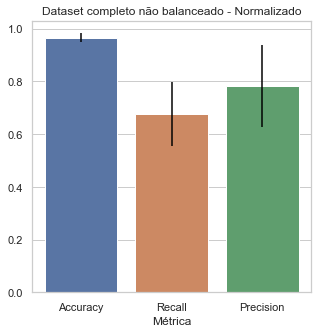

In [22]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Dataset completo não balanceado - Normalizado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Dataset completo nao balanceado - Normalizado - MLPClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

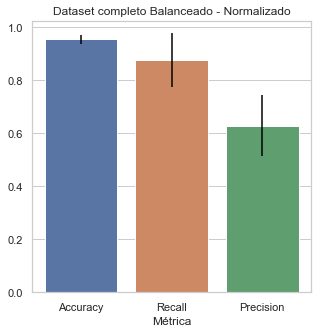

In [23]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Dataset completo Balanceado - Normalizado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Dataset completo balanceado - Normalizado - MLPClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [24]:
path_to_save = '../../model_results/'
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    'MLPClassifier',
    '8',
    'Dataset Completo Desbalanceado - Normalizado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    'MLPClassifier',
    '8',
    'Dataset Completo Balanceado - Normalizado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_balanced[metrica],score_min_balanced.loc[metrica]['Score'], score_max_balanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Algoritmo,Atividade,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Accuracy,0.896129,"[0.896, 0.857, 0.935]"
1,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Recall,0.02,"[0.020, -0.025, 0.065]"
2,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Precision,0.00666667,"[0.007, -0.008, 0.022]"
3,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Accuracy,0.690109,"[0.690, 0.473, 0.907]"
4,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Recall,0.216667,"[0.217, -0.049, 0.482]"
5,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Precision,0.0492712,"[0.049, -0.024, 0.123]"
6,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Accuracy,0.822886,"[0.823, 0.784, 0.862]"
7,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Recall,0.153333,"[0.153, 0.034, 0.272]"
8,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Precision,0.0906421,"[0.091, 0.013, 0.169]"
9,Naive Bayes,6,Branch and Bound Balanceado - Normalizado,0.1,Accuracy,0.512845,"[0.513, 0.416, 0.610]"


Resultados salvos com sucesso
